In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('output.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  3474 non-null   object
 1   email     3474 non-null   object
 2   subject   3474 non-null   object
 3   body      3388 non-null   object
 4   spam      3474 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 135.8+ KB


In [3]:
df = df.dropna(subset='body')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3388 entries, 0 to 3473
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  3388 non-null   object
 1   email     3388 non-null   object
 2   subject   3388 non-null   object
 3   body      3388 non-null   object
 4   spam      3388 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 158.8+ KB


[Text(0, 0, '2735'), Text(0, 0, '653')]

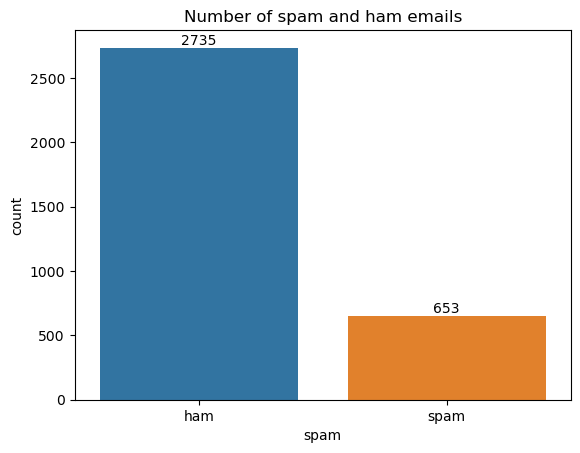

In [5]:
fig = plt.subplots
ax = sns.countplot(x='spam', data=df)
ax.set_title('Number of spam and ham emails')
ax.set_xticklabels(['ham', 'spam'])
ax.bar_label(ax.containers[0])

In [6]:
vectorizer = CountVectorizer()
X_message = vectorizer.fit_transform(df['body'])

encoder = OneHotEncoder()
non_message_features = df[['username', 'email', 'subject']].astype(str).values
X_metadata = encoder.fit_transform(non_message_features)

X_msg_train, X_msg_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    X_message, X_metadata, df['spam'], test_size=0.2, random_state=42
)

In [7]:
nb_model = MultinomialNB()
nb_model.fit(X_msg_train, y_train)
nb_predictions_train = nb_model.predict_proba(X_msg_train)[:, 1]
nb_predictions_test = nb_model.predict_proba(X_msg_test)[:, 1]

nb_test = (nb_predictions_test < 0.5).astype(int)
print(f"Accuracy: {accuracy_score(y_test, nb_test)}")
print(classification_report(y_test, nb_test, zero_division=0))

Accuracy: 0.7684365781710915
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.98      0.96      0.97       545
           2       0.00      0.00      0.00       133

    accuracy                           0.77       678
   macro avg       0.33      0.32      0.32       678
weighted avg       0.79      0.77      0.78       678



In [8]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_meta_train, y_train)
rf_predictions_train = rf_model.predict_proba(X_meta_train)[:, 1]  # Probability of spam
rf_predictions_test = rf_model.predict_proba(X_meta_test)[:, 1]

rf_test = (rf_predictions_test < 0.5).astype(int)
print(f"Accuracy: {accuracy_score(y_test, rf_test)}")
print(classification_report(y_test, rf_test, zero_division=0))

Accuracy: 0.7964601769911505
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.98      0.99      0.99       545
           2       0.00      0.00      0.00       133

    accuracy                           0.80       678
   macro avg       0.33      0.33      0.33       678
weighted avg       0.79      0.80      0.79       678



In [9]:
stacked_train = pd.DataFrame({
    'nb_predictions': nb_predictions_train,
    'rf_predictions': rf_predictions_train
})

stacked_test = pd.DataFrame({
    'nb_predictions': nb_predictions_test,
    'rf_predictions': rf_predictions_test
})

meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train)
final_predictions = meta_model.predict(stacked_test)

print(f"Accuracy: {accuracy_score(y_test, final_predictions)}")
print(classification_report(y_test, final_predictions))

Accuracy: 0.9823008849557522
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       545
           2       0.96      0.95      0.95       133

    accuracy                           0.98       678
   macro avg       0.97      0.97      0.97       678
weighted avg       0.98      0.98      0.98       678



In [10]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, final_predictions))

[[540   5]
 [  7 126]]
